In [4]:
# SHAP values
import shap
shap.initjs()

In [1]:
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline 
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PowerTransformer, PolynomialFeatures
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import RidgeCV

In [5]:
data = pd.read_csv('MobilityDistance/mobility_distance_500_no_impute_sample_Allprop.csv').merge(pd.read_csv('Census_Data/census_table_transformed.csv'), on='census_block_group')

In [6]:
cens_cols = [i for i in data.columns[-45:]]
mob_cols = [i for i in data.columns if '__' in i]

In [7]:
x = data.drop(['property_id','list_price','Latitude','Longitude','census_block_group'], axis=1).dropna()
y = data.dropna().list_price

In [8]:
class custom_mobile(BaseEstimator, TransformerMixin):
    def __init__(self):
        self
    
    def fit(self,X,y=None):
        return self
    
    def transform(self, X, y=None):
        df = X.copy()
        return df[mob_cols]

            
class custom_rest(BaseEstimator, TransformerMixin):
    def __init__(self):
        self

    def fit(self,X, y=None):
        return self

    
    def transform(self,X, y=None):
        df = X.copy()
        return df.drop(mob_cols, axis=1)


mobile_fea = Pipeline([("Mobile",custom_mobile()), ("Mobile_RF", RandomForestRegressor(n_estimators=1000,random_state=11, max_features ='sqrt', min_samples_leaf= 7, min_samples_split= 10))])

rest_fea = Pipeline([("Rest",custom_rest()), ("Rest_RF", RandomForestRegressor(n_estimators=1000,random_state=11, max_features = 'auto', min_samples_leaf= 3, min_samples_split=8))])

sclf_mob = StackingRegressor([('Mob', mobile_fea), ('Res', rest_fea)] , n_jobs=-1, final_estimator = RidgeCV(cv=10))

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=11)

In [9]:

sclf_mob.fit(X_train, y_train)
predictions = sclf_mob.predict(X_test)

mse_mobile = mean_squared_error(y_test, predictions)
print('MSE', round(mse_mobile, 5))
print('R squared', round(sclf_mob.score(X_test, y_test), 5))

MSE 19234023231.50316
R squared 0.8452


In [47]:
sclf_mob.score(X_train, y_train)

0.9497984699506246

In [8]:
NonMob1 = Pipeline([("Rest1",custom_rest()), ("Rest1_RF", RandomForestRegressor(n_estimators=1000,random_state=11, max_features = 'auto', min_samples_leaf= 3, min_samples_split=8))])

NonMob2 = Pipeline([("Rest2",custom_rest()), ("Rest2_RF", RandomForestRegressor(n_estimators=1000,random_state=11, max_features = 'auto', min_samples_leaf= 3, min_samples_split=8))])

sclf_non = StackingRegressor([('All1', NonMob1), ('All2', NonMob2)] , n_jobs=-1, final_estimator = RidgeCV(cv=10))

In [9]:
sclf_non.fit(X_train, y_train)
predictions = sclf_non.predict(X_test)

mse_non_mobile = mean_squared_error(y_test, predictions)
print('MSE', round(mse_non_mobile, 5))
print('R squared', round(sclf_non.score(X_test, y_test), 5))

Ill-conditioned matrix (rcond=4.49406e-17): result may not be accurate.
Ill-conditioned matrix (rcond=9.93613e-17): result may not be accurate.
Ill-conditioned matrix (rcond=1.72674e-17): result may not be accurate.
Ill-conditioned matrix (rcond=5.67978e-17): result may not be accurate.
Ill-conditioned matrix (rcond=9.45891e-17): result may not be accurate.
Ill-conditioned matrix (rcond=5.28846e-17): result may not be accurate.
Ill-conditioned matrix (rcond=5.62865e-17): result may not be accurate.
Ill-conditioned matrix (rcond=4.99968e-17): result may not be accurate.
Ill-conditioned matrix (rcond=8.89782e-17): result may not be accurate.
Ill-conditioned matrix (rcond=5.61032e-17): result may not be accurate.


MSE 19821559439.39054
R squared 0.84048


In [10]:
(mse_mobile-mse_non_mobile)/mse_non_mobile

-0.029641270641895135

In [40]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer


parameter_space_rf = {
                   'Mob__Mobile_RF__min_samples_split':Integer(2,10),
                   'Mob__Mobile_RF__min_samples_leaf': Integer(1,10),
                   'Mob__Mobile_RF__max_features': Categorical(['auto', 'sqrt']),
                   'Mob__Mobile_RF__bootstrap': Categorical([True,False]),
                   #'Mob__Mobile_RF__max_depth': Integer(1000,100000),
                   #'Mob__Mobile_RF__n_estimators': Integer(50,1000),
                   'Res__Rest_RF__min_samples_split':Integer(2,10),
                   'Res__Rest_RF__min_samples_leaf': Integer(1,10),
                   'Res__Rest_RF__max_features': Categorical(['auto', 'sqrt']),
                   'Res__Rest_RF__bootstrap': Categorical([True,False]),
                   #'Res__Rest_RF__max_depth': Integer(1000,100000),
                   #'Res__Rest_RF__n_estimators': Integer(50,1000)
                  }

search_rf = BayesSearchCV(estimator=sclf_mob, search_spaces=parameter_space_rf, n_jobs=-1, cv=10, scoring='neg_mean_squared_error', n_iter=10, verbose=4)

search_rf.fit(X_train, y_train)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


BayesSearchCV(cv=10,
              estimator=StackingRegressor(estimators=[('Mob',
                                                       Pipeline(steps=[('Mobile',
                                                                        custom_mobile()),
                                                                       ('Mobile_RF',
                                                                        RandomForestRegressor(n_estimators=500,
                                                                                              random_state=11))])),
                                                      ('Res',
                                                       Pipeline(steps=[('Rest',
                                                                        custom_rest()),
                                                                       ('Rest_RF',
                                                                        RandomForestRegressor(n_estimators=500,
       

In [41]:
print(search_rf.best_params_)

OrderedDict([('Mob__Mobile_RF__bootstrap', True), ('Mob__Mobile_RF__max_features', 'sqrt'), ('Mob__Mobile_RF__min_samples_leaf', 7), ('Mob__Mobile_RF__min_samples_split', 10), ('Res__Rest_RF__bootstrap', True), ('Res__Rest_RF__max_features', 'auto'), ('Res__Rest_RF__min_samples_leaf', 3), ('Res__Rest_RF__min_samples_split', 8)])


In [10]:
import shap

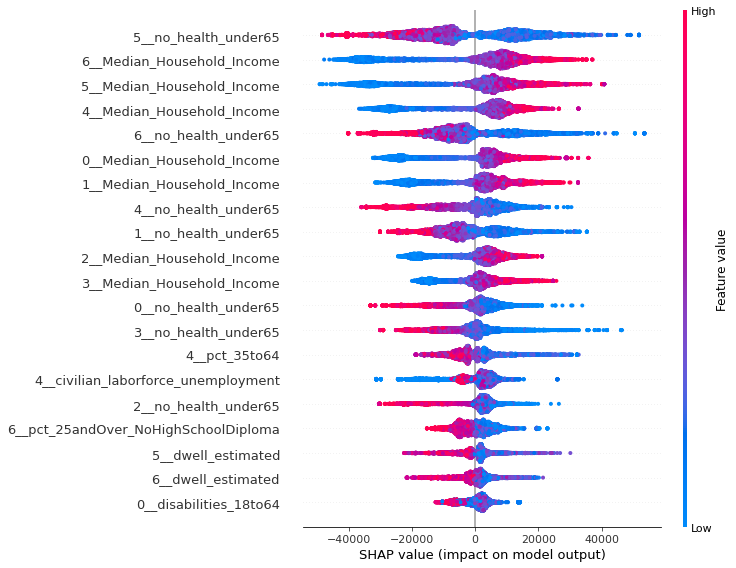

In [11]:
X100 = shap.utils.sample(X_train, 200)
#ex = shap.TreeExplainer(rfr, X_train)

ex = shap.TreeExplainer(sclf_mob.estimators_[0][1])
shap_values = ex.shap_values(X_train[mob_cols])
shap.summary_plot(shap_values, X_train[mob_cols], max_display=20)

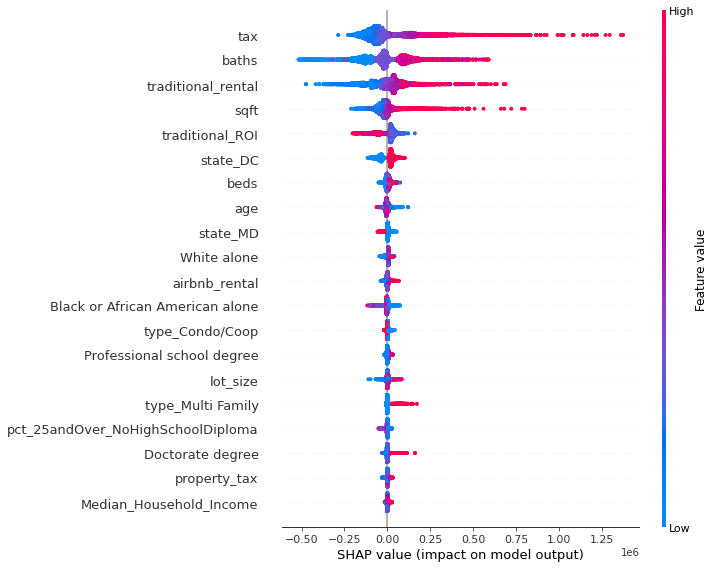

In [11]:
X100 = shap.utils.sample(X_train.drop(mob_cols, axis=1), 100)
#ex = shap.TreeExplainer(rfr, X_train)

ex = shap.TreeExplainer(sclf_mob.estimators_[1][1])
shap_values = ex.shap_values(X_train.drop(mob_cols, axis=1))
shap.summary_plot(shap_values, X_train.drop(mob_cols, axis=1), max_display=20)